In [3]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!tar -xvf /content/drive/MyDrive/ML_Assignment/data/hazelnut.tar.xz -C /content/drive/MyDrive/ML_Assignment/data/


hazelnut/
hazelnut/ground_truth/
hazelnut/ground_truth/crack/
hazelnut/ground_truth/crack/017_mask.png
hazelnut/ground_truth/crack/000_mask.png
hazelnut/ground_truth/crack/001_mask.png
hazelnut/ground_truth/crack/002_mask.png
hazelnut/ground_truth/crack/003_mask.png
hazelnut/ground_truth/crack/004_mask.png
hazelnut/ground_truth/crack/005_mask.png
hazelnut/ground_truth/crack/006_mask.png
hazelnut/ground_truth/crack/007_mask.png
hazelnut/ground_truth/crack/008_mask.png
hazelnut/ground_truth/crack/009_mask.png
hazelnut/ground_truth/crack/010_mask.png
hazelnut/ground_truth/crack/011_mask.png
hazelnut/ground_truth/crack/012_mask.png
hazelnut/ground_truth/crack/013_mask.png
hazelnut/ground_truth/crack/014_mask.png
hazelnut/ground_truth/crack/015_mask.png
hazelnut/ground_truth/crack/016_mask.png
hazelnut/ground_truth/cut/
hazelnut/ground_truth/cut/000_mask.png
hazelnut/ground_truth/cut/001_mask.png
hazelnut/ground_truth/cut/002_mask.png
hazelnut/ground_truth/cut/003_mask.png
hazelnut/ground_t

In [9]:
!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 85.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 104.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 123.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.6 MB/s eta 0:00:00


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

In [11]:
print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [18]:
HAZELNUT_PATH = '/content/drive/MyDrive/ML_Assignment/data/hazelnut'
train_dir = os.path.join(HAZELNUT_PATH, 'train')
test_dir = os.path.join(HAZELNUT_PATH, 'test')

In [19]:
import shutil
import pathlib

def prepare_binary_class_folders(original_dir, output_dir):
    """
    original_dir: path to original train or test folder with multiple subfolders
    output_dir: path to output folder with two subfolders: 'defective' and 'non_defective'
    """
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)
    os.makedirs(os.path.join(output_dir, 'defective'))
    os.makedirs(os.path.join(output_dir, 'non_defective'))

    for class_folder in os.listdir(original_dir):
        class_path = os.path.join(original_dir, class_folder)
        if not os.path.isdir(class_path):
            continue

        # Determine class label
        if class_folder == 'good':
            label_folder = 'non_defective'
        else:
            label_folder = 'defective'

        # Copy all images
        for img_file in os.listdir(class_path):
            src = os.path.join(class_path, img_file)
            dst = os.path.join(output_dir, label_folder, img_file)
            shutil.copy(src, dst)

In [28]:
# Prepare train and test folders for binary classification
import os

# Use the original train/test folders from Google Drive as input
train_dir = '/content/drive/MyDrive/ML_Assignment/data/hazelnut/train'
test_dir = '/content/drive/MyDrive/ML_Assignment/data/hazelnut/test'

# Create binary folders locally on Colab's disk (temp storage)
binary_train_dir = '/content/hazelnut_train_binary'
binary_test_dir = '/content/hazelnut_test_binary'

# Then call the prepare_binary_class_folders function with these paths
prepare_binary_class_folders(train_dir, binary_train_dir)
prepare_binary_class_folders(test_dir, binary_test_dir)


print("Binary folders prepared:")
print("Train:", os.listdir(binary_train_dir))
print("Test:", os.listdir(binary_test_dir))

Binary folders prepared:
Train: ['defective', 'non_defective']
Test: ['defective', 'non_defective']


**Issue:**  
The training dataset initially had **only 'good' (non-defective) images**, while all defective images were in the test set. This caused the model to  verfit to one class, resulting in 100% training accuracy and 50% validation accuracy.

**Fix:**  
Moved **10 defective images from the test set to the training set** to ensure both classes were represented during training.  
Recomputed class weights and re-trained the model.

**Outcome:**  
Validation accuracy improved, validation loss stabilized, and the model could finally learn to distinguish between defective and non-defective images.

**Lesson:**  
Always verify **class balance in both train and test sets** before training.


In [36]:
import os
import shutil
import random

# Paths
test_defect_folder = '/content/hazelnut_test_binary/defective'
train_defect_folder = '/content/hazelnut_train_binary/defective'

# Create defective folder inside train if it doesn't exist
if not os.path.exists(train_defect_folder):
    os.makedirs(train_defect_folder)

# List all defective images in test folder
images = os.listdir(test_defect_folder)
print(f"Found {len(images)} images in test defective folder.")

# Select up to 10 images to move (or all if less)
num_to_move = min(10, len(images))
images_to_move = random.sample(images, num_to_move)

# Move images
for img in images_to_move:
    src = os.path.join(test_defect_folder, img)
    dst = os.path.join(train_defect_folder, img)
    shutil.move(src, dst)

print(f"Moved {num_to_move} images from test/defective to train/defective.")

# Check final counts
def count_images(folder_path):
    counts = {}
    for subdir in os.listdir(folder_path):
        dir_path = os.path.join(folder_path, subdir)
        if os.path.isdir(dir_path):
            counts[subdir] = len(os.listdir(dir_path))
    return counts

print("\nTrain data count after move:", count_images('/content/hazelnut_train_binary'))
print("Test data count after move:", count_images('/content/hazelnut_test_binary'))


Found 18 images in test defective folder.
Moved 10 images from test/defective to train/defective.

Train data count after move: {'defective': 10, 'non_defective': 391}
Test data count after move: {'defective': 8, 'non_defective': 40}


In [45]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# --- Data Generators with Augmentation ---
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    zoom_range=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    '/content/hazelnut_train_binary',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    '/content/hazelnut_test_binary',
    target_size=(224, 224),
    batch_size=16,
    class_mode='binary',
    shuffle=False
)

print("Class Indices:", train_generator.class_indices)

# --- Class Weights ---
from sklearn.utils.class_weight import compute_class_weight

classes = np.array([0, 1])
counts = np.array([391, 10])
class_weights = dict(zip(classes, (counts.sum() / (len(classes) * counts)).tolist()))
print("Class Weights:", class_weights)

# --- Build MobileNetV2 Transfer Learning Model ---
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
base_model.trainable = False  # freeze base model

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()



Found 401 images belonging to 2 classes.
Found 48 images belonging to 2 classes.
Class Indices: {'defective': 0, 'non_defective': 1}
Class Weights: {np.int64(0): 0.5127877237851662, np.int64(1): 20.05}


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [46]:
# --- Train ---
EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator,
    class_weight=class_weights,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6268 - loss: 12.4071

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


26/26 ━━━━━━━━━━━━━━━━━━━━ 51s 2s/step - accuracy: 0.6353 - loss: 12.1281 - val_accuracy: 0.8333 - val_loss: 0.9541
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.9848 - loss: 0.1520 - val_accuracy: 0.8333 - val_loss: 1.1205
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9801 - loss: 0.1094 - val_accuracy: 0.8333 - val_loss: 1.1534
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9743 - loss: 0.1257 - val_accuracy: 0.8333 - val_loss: 1.1715
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9758 - loss: 0.1163 - val_accuracy: 0.8333 - val_loss: 1.1893
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step - accuracy: 0.9694 - loss: 0.1362 - val_accuracy: 0.8333 - val_loss: 1.2083


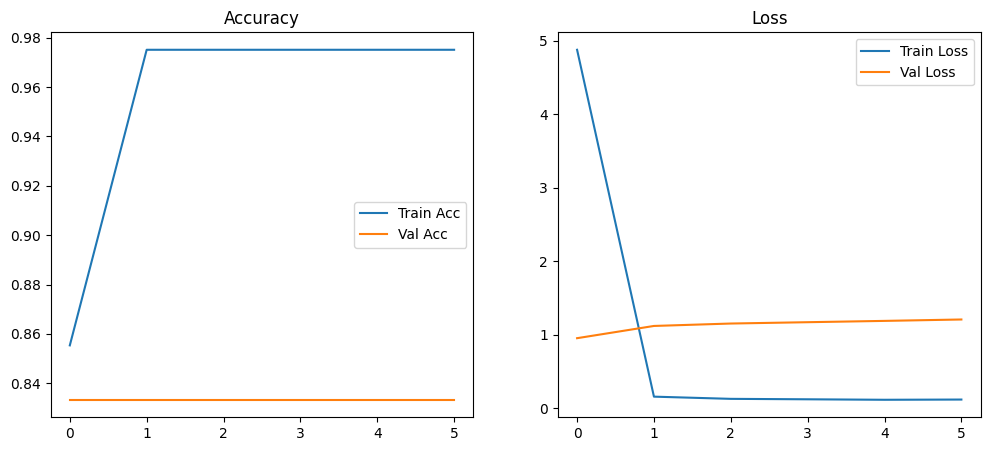

In [47]:
def plot_history(history):
    plt.figure(figsize=(12,5))

    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.legend()

    plt.show()

plot_history(history)


In [48]:
# --- Evaluate on Test Set ---
probs = model.predict(test_generator)
preds = (probs > 0.5).astype(int).reshape(-1)
true_labels = test_generator.classes

print("Unique true labels:", np.unique(true_labels))
print("Unique predicted labels:", np.unique(preds))

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step
Unique true labels: [0 1]
Unique predicted labels: [1]


In [49]:
# Evaluate on Test Data
test_generator.reset()
pred_probs = model.predict(test_generator)
preds = (pred_probs > 0.5).astype(int)
true_labels = test_generator.classes


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step


In [50]:
acc = accuracy_score(true_labels, preds)
prec = precision_score(true_labels, preds, average='weighted')
rec = recall_score(true_labels, preds, average='weighted')
f1 = f1_score(true_labels, preds, average='weighted')

print(f"Test Accuracy: {acc:.4f}")
print(f"Test Precision: {prec:.4f}")
print(f"Test Recall: {rec:.4f}")
print(f"Test F1 Score: {f1:.4f}")


Test Accuracy: 0.8333
Test Precision: 0.6944
Test Recall: 0.8333
Test F1 Score: 0.7576


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [52]:
# --- Classification Report ---
print("Classification Report:")
print(classification_report(true_labels, preds, target_names=['Non-defective', 'Defective']))

Classification Report:
               precision    recall  f1-score   support

Non-defective       0.00      0.00      0.00         8
    Defective       0.83      1.00      0.91        40

     accuracy                           0.83        48
    macro avg       0.42      0.50      0.45        48
 weighted avg       0.69      0.83      0.76        48



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


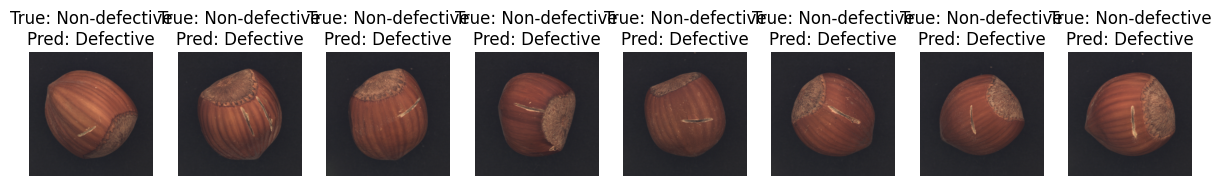

In [53]:
# --- Display some predictions with images ---
import matplotlib.image as mpimg

def plot_sample_predictions(generator, preds, n=5):
    plt.figure(figsize=(15,5))
    for i in range(n):
        img_path = generator.filepaths[i]
        img = mpimg.imread(img_path)
        plt.subplot(1,n,i+1)
        plt.imshow(img)
        plt.axis('off')
        true_label = 'Defective' if generator.classes[i]==1 else 'Non-defective'
        pred_label = 'Defective' if preds[i]==1 else 'Non-defective'
        plt.title(f"True: {true_label}\nPred: {pred_label}")
    plt.show()

plot_sample_predictions(test_generator, preds, n=8)